# Error investigation


In [181]:
%cd "~/projects/spartDM"
%load_ext autoreload
%autoreload 2

import os

print(f"Current working dir: {os.getcwd()}")

/home/kdang/projects/spartDM
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working dir: /home/kdang/projects/spartDM


/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [182]:
import numpy as np
from src.data.starmen import StarmenDataset
from monai.data import DataLoader
from src.sadm.utils import plot_multi_imgs
from src.utils.metrics import percnorm, ssim, mse, mae
import json
import torch
import torch.nn.functional as F
from monai.transforms import ScaleIntensity
from einops import rearrange
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


In [ ]:
DATA_DIR = "data/starmen/output_random_noacc"
WORK_DIR = "workdir/diffae_resnet18_ep1000"

test_ds = StarmenDataset(
    data_dir=DATA_DIR,
    split="gcircle10",
    nb_subject=None,
)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)



# Read the reconstruction error files to get the index and corresponding reonconstruction image
eval_error_path = os.path.join(WORK_DIR, "evals_errors_gcircle10_50step.json")
with open(eval_error_path, "r") as f:
    eval_error = json.load(f)

test_ids = [i["id"] for i in eval_error]

x_recons_path = os.path.join(WORK_DIR, "x_recons_gcircle10_50step.npy")
x_recons = np.load(x_recons_path)


# Load the original (anomalious) image from test dataset by index
x_orgs = [test_ds.get_images_by_id(id).squeeze() for id in test_ids]
x_orgs = np.stack(x_orgs).astype("float32")

# Load the ground_truth anomaly maps
ano_gts = []
for id in test_ids:
    gt_path = test_ds.datas[test_ds.datas["id"] == 215]["gt_path"].unique().item()
    gt = np.load(gt_path)
    ano_gts.append(gt)
ano_gts = np.stack(ano_gts)


# Calculate errors
x_diffs = abs(x_orgs - x_recons)




In [233]:
ano_diffs = ano_gts * x_diffs
ano_diffs_t = rearrange(ano_diffs, "b t h w -> t (b h w)")
ano_diffs_ls = ano_diffs_t.tolist()

ano_diffs_filter = []

for ano in ano_diffs_ls:
    filter_ano = [i for i in ano if i != 0]
    ano_diffs_filter.append(filter_ano)



## Plot reconstruction error 

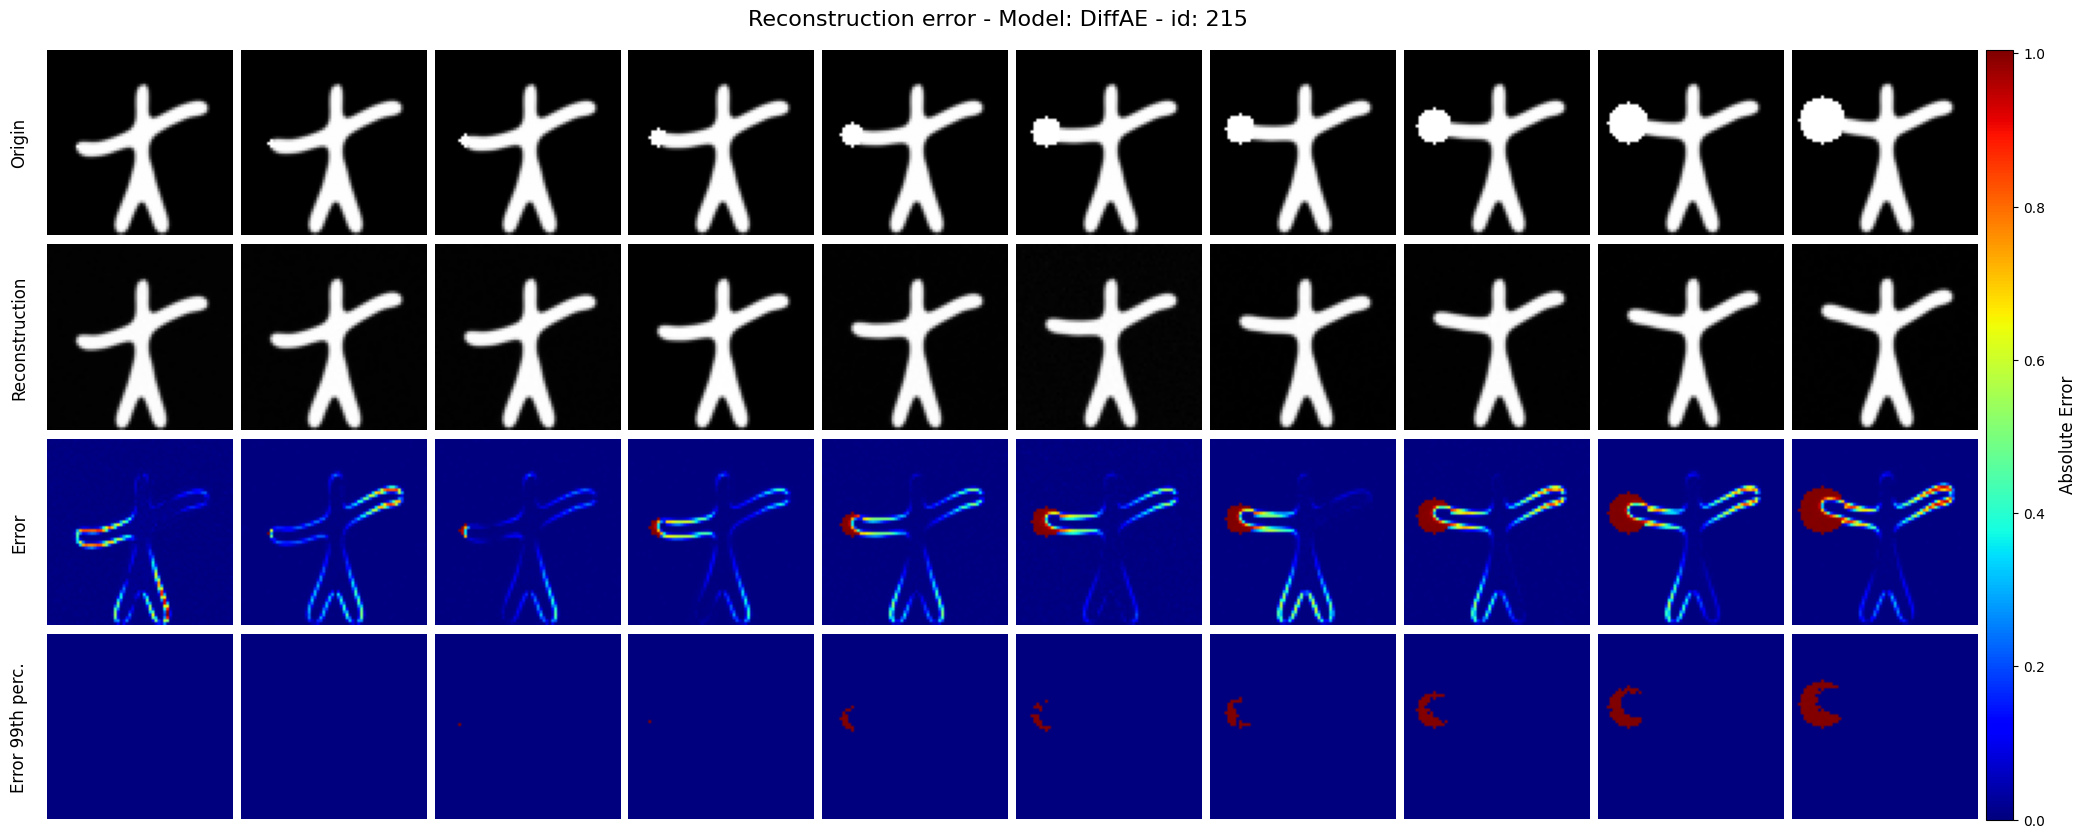

In [221]:
from src.utils import plot_comparison_starmen

# Calculate 99th percentile of error
# and use it as value-filter
from src.utils.metrics import error_filter
filter_perc = 99
filter_value = np.percentile(x_diffs, filter_perc)
x_diffs_filter = error_filter(x_diffs, filter_value)

# Choose 1 index for example
id = 0
img_org = x_orgs[id]
img_recons = x_recons[id]
img_diff = x_diffs[id]
img_diff_filter = x_diffs_filter[id]

imgs = [
    img_org, 
    img_recons,
    img_diff,
    img_diff_filter
]

labels = [
    "Origin",
    "Reconstruction",
    "Error",
    f"Error {filter_perc}th perc."
]

title = f"Reconstruction error - Model: DiffAE - id: {test_ids[id]}"
opt={"title":title}

plot_comparison_starmen(imgs, labels, is_errors=[False, False, True, True], show=True, opt=opt)

## Plot histogram error

(10, 10, 64, 64)


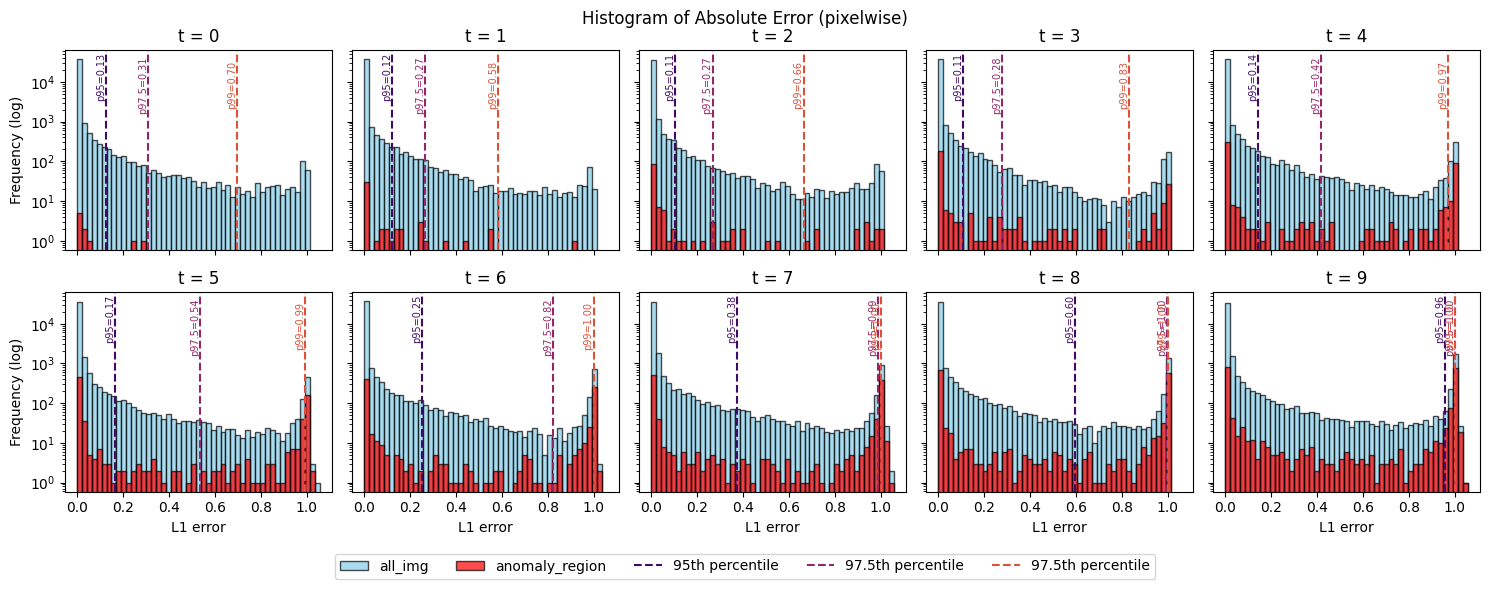

In [234]:
import numpy as np
from src.utils import plot_error_histogram

def mask_region(arr, top_left, size, mask_value=0):
    """
    Masks a rectangular region in a 2D or 3D NumPy array.

    Parameters:
        arr (np.ndarray): The input array (2D or 3D).
        top_left (tuple): (row, col) coordinates of the top-left corner.
        size (tuple): (height, width) of the region to mask.
        mask_value (numeric): Value to fill in the masked region. Default is 0.

    Returns:
        np.ndarray: A new array with the masked region.
    """
    masked_arr = np.zeros_like(arr)
    r, c = top_left
    h, w = size

    masked_arr[..., r:r+h, c:c+w] = arr[..., r:r+h, c:c+w]
    return masked_arr


anomaly_diff = mask_region(x_diffs, (10, 10), (10, 10))
print(anomaly_diff.shape)


# Calculate histogram of error for each timeline

diff_t = rearrange(x_diffs, "b t h w -> t (b h w)")

plot_error_histogram(
    diff_t,
    ano_diffs_filter,
    opt={"title": "Histogram of Absolute Error (pixelwise)"}
)

## Compute metrics

We will compute the MSE (per-image), MAE (per pixel) and SSIM, and then report the mean and sd of these metrics for each number of steps (50, 100, 250, 500). 

In [ ]:
# Get the reconstruction images for each nb of steps



ddim_var = ["50step", "100step", "250step", "500step"]

all_results = []

for v in ddim_var:

    result = {"method": v}

    eval_error_path = os.path.join(WORK_DIR, f"evals_errors_{v}.json")
    with open(eval_error_path, "r") as f:
        eval_error = json.load(f)

    test_ids = [i["id"] for i in eval_error]

    # Get x origin that follows index of test_ids
    x_orgs = [test_ds.get_images_by_id(id).squeeze() for id in test_ids]
    x_orgs = np.stack(x_orgs)

    # Get reconstruction image
    x_recons_path = os.path.join(WORK_DIR, f"x_recons_{v}.npy")
    x_recons = np.load(x_recons_path)

    # Calculate metric
    t_x_orgs = torch.from_numpy(x_orgs)
    t_x_recons = torch.from_numpy(x_recons)

    mean_mse, sd_mse, _ = mse(t_x_orgs, t_x_recons)
    mean_mae, sd_mae, _ = mae(t_x_orgs, t_x_recons)

    # Calculate SSIM metrics
    # Since SSIM requires x and x_recons have the same data_range, we will rescale x_recons to [0, 1]
    # also, we apply the clipping of 5% and 95% percentile to x_recons

    scale = ScaleIntensity(0, 1)
    x_recons_norm = scale(x_recons).numpy()
    x_recons_norm = percnorm(x_recons_norm, 5, 95)
    t_x_recons_norm = torch.from_numpy(x_recons_norm)

    ssim_all = ssim(
        rearrange(t_x_orgs, "b t h w -> (b t) 1 h w"),
        rearrange(t_x_recons, "b t h w -> (b t) 1 h w")
    )

    # write resule
    result["mean_ssim"] = np.mean(ssim_all)
    result["max_ssim"] = np.max(ssim_all)
    result["sd_ssim"] = np.std(ssim_all)
    result["mean_mse"] = mean_mse.item()
    result["sd_mse"] = sd_mse.item()
    result["mean_mae"] = mean_mae.item()
    result["sd_mae"] = sd_mae.item()

    all_results.append(result)

    

In [226]:
import pandas as pd


df = pd.DataFrame(all_results)
print(df)

csv_path = os.path.join(WORK_DIR, "metrics_summary.csv")
df.to_csv(csv_path, index=False) 


    method  mean_ssim  max_ssim   sd_ssim  mean_mse    sd_mse  mean_mae  \
0   50step   0.945531  0.997767  0.044143  0.003651  0.005714  0.014734   
1  100step   0.941372  0.998222  0.049418  0.003748  0.005718  0.015573   
2  250step   0.626122  0.990827  0.236446  0.009302  0.009009  0.048504   
3  500step   0.509220  0.985161  0.200003  0.015265  0.009550  0.068388   

     sd_mae  
0  0.008548  
1  0.008819  
2  0.028376  
3  0.026858  
